In [1]:
%run ../scripts/imports.py

data_path = open("../path_data.txt", 'r').readline()

Succesfully imported libraries and modules



## Introduction

The goal is to construct:
1) Mean comodulogram OFF vs ON for each patient and day (inter-PAC)
2) Same, cross-PAC (make sure inter- and cross- are aligned)
3) Global mean inter-PAC OFF vs ON
4) Global mean cross-PAC OFF vs ON
5) Global PAC OFF vs ON

In [3]:
patients = [load_patient(i, data_path, load_pac=True) for i in range(1, 10)]

Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient1
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient2
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient3
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient4
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient5
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient6
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient7
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient8
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient9


In [5]:
cross_placements = ["L4-3A", "L4-3B", "L4-3C", "L2A-3A", "L2B-3B", "L2C-3C", "L1-2A", "L1-2B", "L1-2C", 
                    "R4-3A", "R4-3B", "R4-3C", "R2A-3A", "R2B-3B", "R2C-3C", "R1-2A", "R1-2B", "R1-2C"]

for patient in patients:
    patient.cross_placements = cross_placements

### Load all cross- and inter- PACs

In [43]:
# each would contain an array of shape n_pacs x shape(pac_matrix)
cross_pacs_for_patient_off = [[] for _ in range(len(patients))]
inter_pacs_for_patient_off = [[] for _ in range(len(patients))]
all_pacs_for_patient_off = [[] for _ in range(len(patients))]

cross_pacs_for_patient_on = [[] for _ in range(len(patients))]
inter_pacs_for_patient_on = [[] for _ in range(len(patients))]
all_pacs_for_patient_on = [[] for _ in range(len(patients))]

for i, patient in enumerate(patients):
    
    conditions = [c for c in patient.conditions if 'Rest 180sec' in c]
    print(conditions)
    for condition in tqdm(conditions, total=len(conditions)):
        day, ldopa, movement = retrieve_condition_name(condition)
        for pp in patient.placements:
            for pa in patient.placements:
                if not pac_exists(patient, condition, pp, pa):
                    continue
                
                # if irrelevant cross-PAC (not all conditions will be available)
                if (pp != pa) and (pp not in patient.cross_placements or pa not in patient.cross_placements):
                    continue

                # Get PAC power
                pac = patient.pac[condition][pp][pa]

                ## getting only significant PAC + leaving only "clustered" entries
                sig_pac = get_sig_pac(pac, significance=0.01, mask_lonely=True)

                ## if cross_pac
                if (pp != pa) and sig_pac.shape == (19, 27):
                    res = sig_pac
                    # append cross_pac
                    if ldopa == 'OFF':
                        cross_pacs_for_patient_off[i].append(res)
                    if ldopa == 'ON':
                        cross_pacs_for_patient_on[i].append(res)
                else:
                    # reduce size to match cross-PAC
                    beta10 = np.argmin(np.abs(pac.beta_freqs - 10))
                    beta36 = np.argmin(np.abs(pac.beta_freqs - 36))
                    hfo140 = np.argmin(np.abs(pac.hfo_freqs - 140))
                    res = sig_pac[hfo140:, beta10:beta36 + 1]
                    # append inter-PAC
                    if ldopa == 'OFF':
                        inter_pacs_for_patient_off[i].append(res)
                    if ldopa == 'ON':
                        inter_pacs_for_patient_on[i].append(res)
                # append PAC no matter inter- or cross-
                if ldopa == 'OFF':
                        all_pacs_for_patient_off[i].append(res)
                if ldopa == 'ON':
                        all_pacs_for_patient_on[i].append(res)

                #print(f"{pp}-{pa}: {res.shape}")
    # after computing one patients convert to np.arrays
    cross_pacs_for_patient_off[i] = np.array(cross_pacs_for_patient_off[i])
    inter_pacs_for_patient_off[i] = np.array(inter_pacs_for_patient_off[i])
    all_pacs_for_patient_off[i] = np.array(all_pacs_for_patient_off[i])

    cross_pacs_for_patient_on[i] = np.array(cross_pacs_for_patient_on[i])
    inter_pacs_for_patient_on[i] = np.array(inter_pacs_for_patient_on[i])
    all_pacs_for_patient_on[i] = np.array(all_pacs_for_patient_on[i])

['1Day ON Rest 180sec', '5Day ON Rest 180sec', '5Day OFF Rest 180sec', '1Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['5Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day ON Rest 180sec', '1Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['1Day ON Rest 180sec', '5Day ON Rest 180sec', '5Day OFF Rest 180sec', '1Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['5Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day ON Rest 180sec', '1Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['5Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day ON Rest 180sec', '1Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['1Day ON Rest 180sec', '1Day OFF Rest 180sec']


  0%|          | 0/2 [00:00<?, ?it/s]

['1Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day ON Rest 180sec', '5Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['1Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day ON Rest 180sec', '5Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['1Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day ON Rest 180sec', '5Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

#### Checking inter- and cross- PAC shape alignment

In [9]:
p1 = patients[0]
condition = '1Day OFF Rest 180sec'
pp = 'L1-2A'
pa = "L2A-3A"

inter_pac = p1.pac[condition][pp][pp]
cross_pac = p1.pac[condition][pp][pa]

In [10]:
inter_pac.beta_freqs

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [11]:
cross_pac.beta_freqs

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36])

In [12]:
beta10 = np.argmin(np.abs(pac.beta_freqs - 10))
beta36 = np.argmin(np.abs(pac.beta_freqs - 36))


inter_pac.beta_freqs[beta10:beta36+1]

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [13]:
hfo140 = np.argmin(np.abs(pac.hfo_freqs - 140))

inter_pac.hfo_freqs[hfo140:]

array([ 40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280,
       300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500])

In [14]:
cross_pac.hfo_freqs

array([140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380,
       400, 420, 440, 460, 480, 500])

In [15]:
inter_pac.pac_matrix[hfo140:, beta10:beta35+1].shape

NameError: name 'beta35' is not defined

In [16]:
cross_pac.pac_matrix.shape

(19, 27)

## Inter-PAC by patient

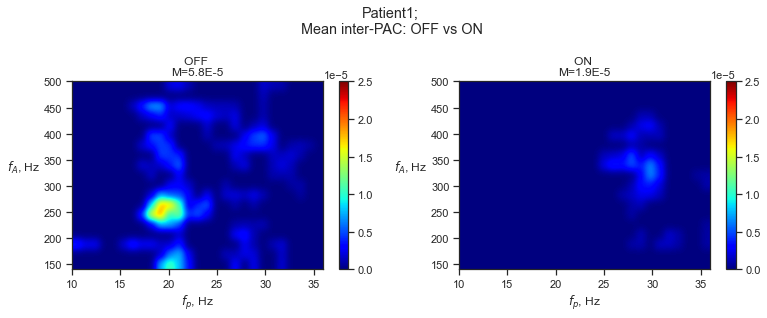

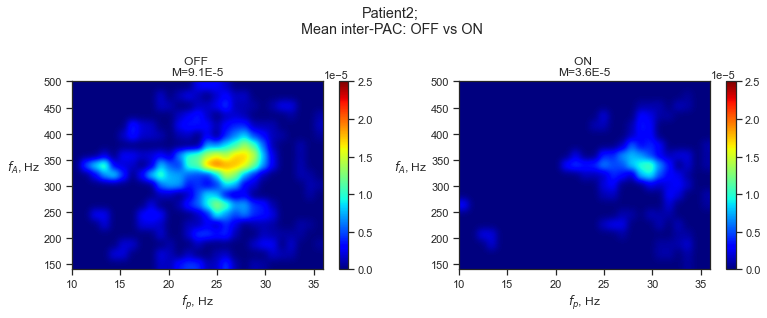

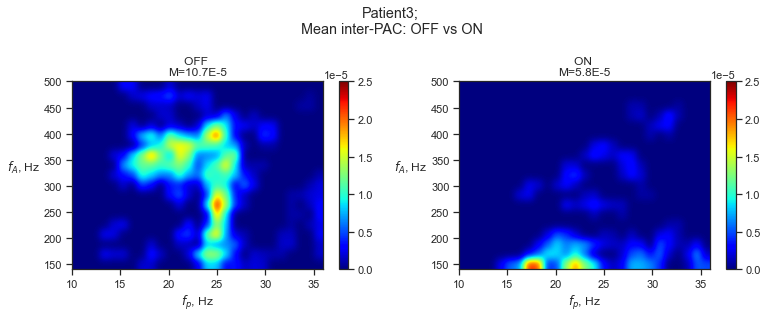

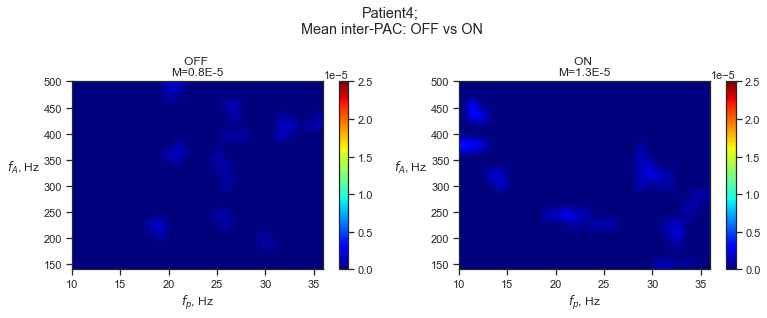

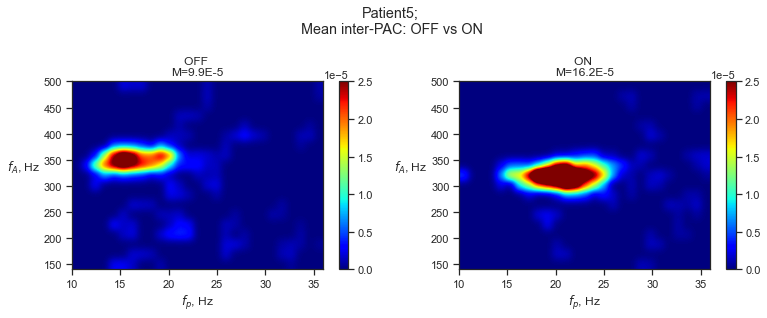

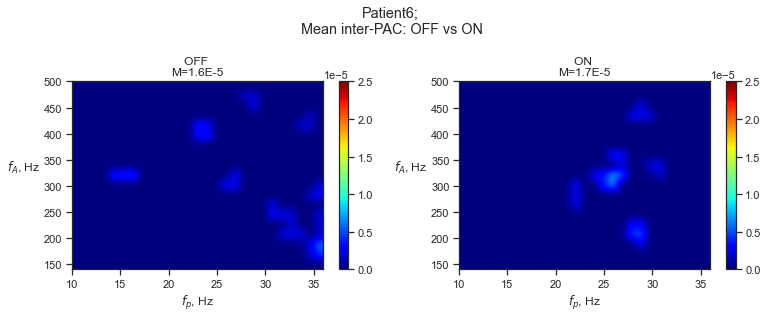

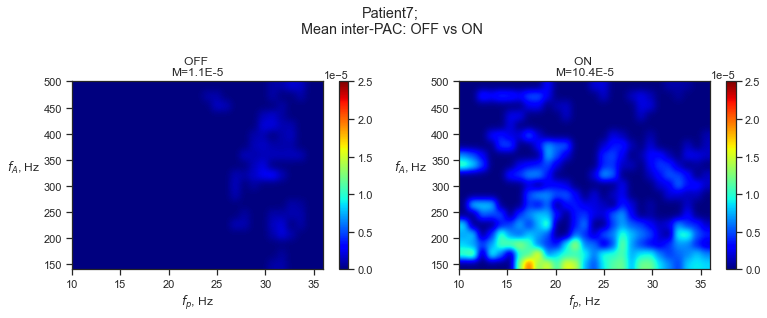

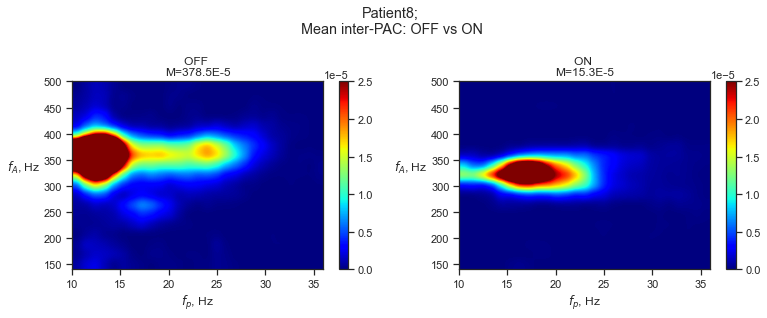

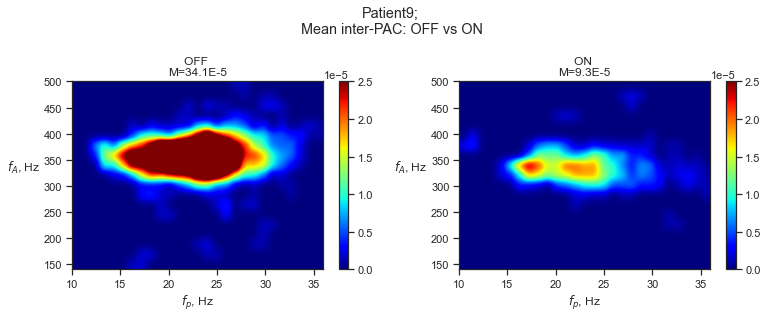

In [45]:
beta_params = cross_pac.beta_params
hfo_params = cross_pac.hfo_params

p8_divisor = 10

vmax = 2.5e-5

with open('../path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'Mean PAC comodulograms', 'by patients')

try:
    os.makedirs(save_path)
except:
    pass


for i in range(len(patients)):
    patient = patients[i]
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    plt.suptitle(f"{patient.name};\n Mean inter-PAC: OFF vs ON")
    
    ax = axes[0]
    data = inter_pacs_for_patient_off[i]
    if i == 7: data = data / p8_divisor
    im = comodulogram(data.mean(axis=0), 
                     beta_params, 
                     hfo_params, 
                     pvalues=cross_pac.pvalues, 
                     significant=False, significance=0.01,
                     vmax=vmax, smooth=True,
                     ax=ax)
    norm = compute_matrix_norm(inter_pacs_for_patient_off[i].mean(axis=0))
    ax.set_title(f"OFF \nM={norm * 1e5:.1f}E-5")
    ax.set_xlabel(r"$f_p$, Hz")
    ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
    cbar = fig.colorbar(im, ax=ax)
    cbar.formatter.set_powerlimits((0, 0))
    #ax.grid()
    
    ax = axes[1]
    data = inter_pacs_for_patient_on[i]
    if i == 7: data /= p8_divisor
    im = comodulogram(data.mean(axis=0), 
                     beta_params, 
                     hfo_params,
                     pvalues=cross_pac.pvalues, 
                     significant=False, significance=0.01,
                     vmax=vmax, smooth=True,
                     ax=ax)
    norm = compute_matrix_norm(inter_pacs_for_patient_on[i].mean(axis=0))
    ax.set_title(f"ON \nM={norm * 1e5:.1f}E-5")
    ax.set_xlabel(r"$f_p$, Hz")
    ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
    cbar = fig.colorbar(im, ax=ax)
    cbar.formatter.set_powerlimits((0, 0))
    #ax.grid()
    plt.tight_layout()
    fig_path = os.path.join(save_path, f"{patient.name} Mean inter-PAC OFF vs ON.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')

## Cross-PAC by patient

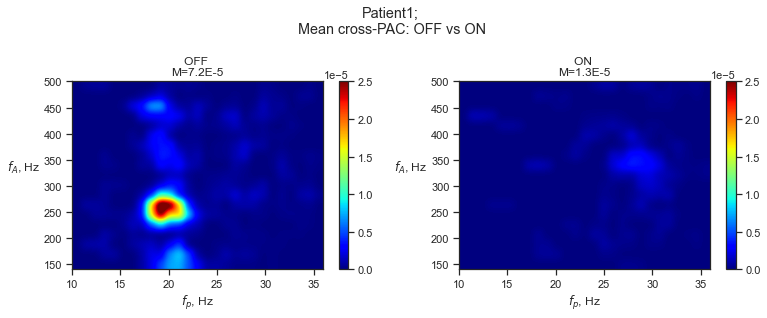

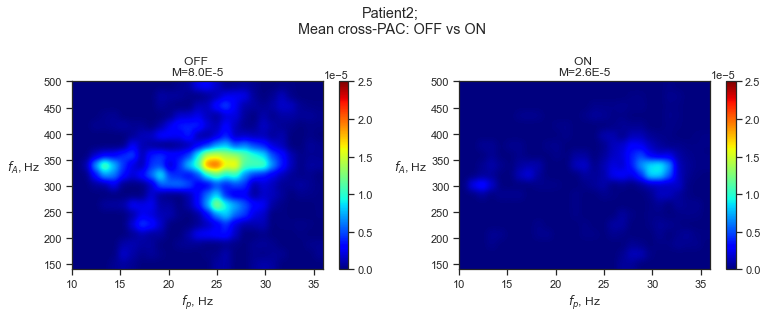

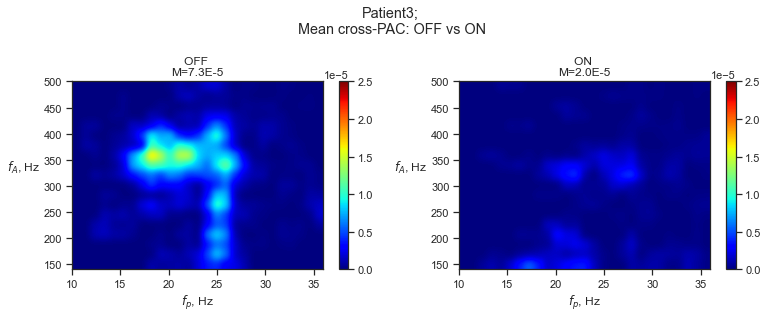

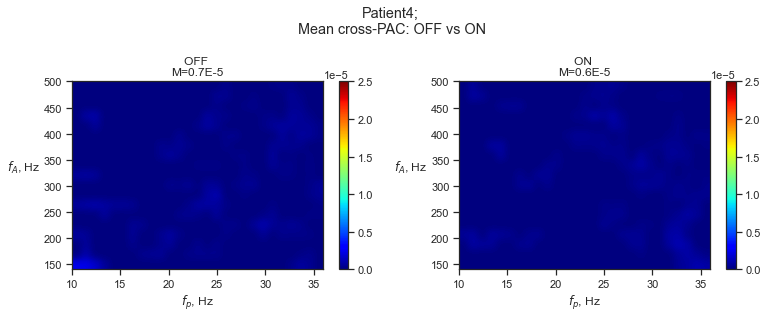

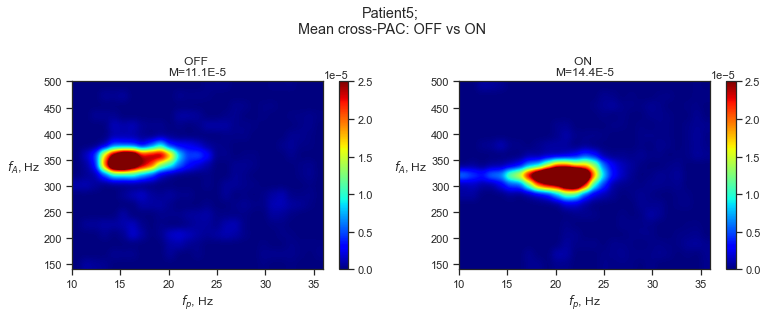

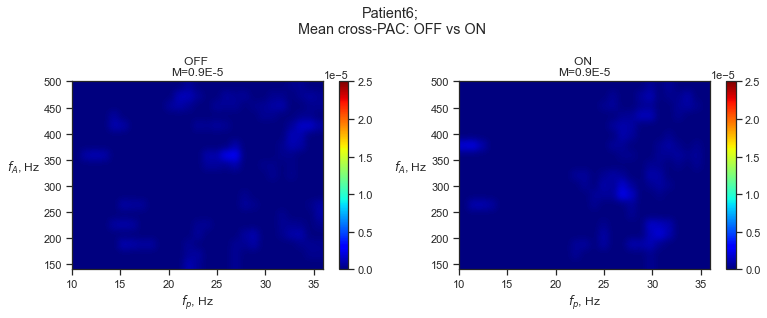

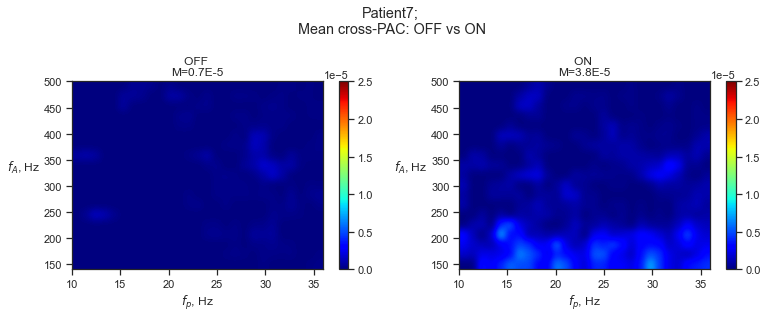

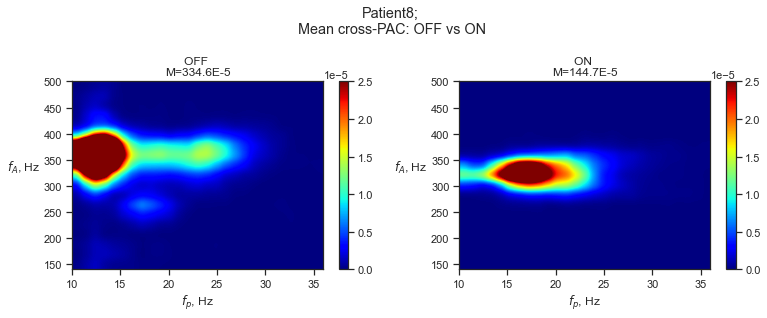

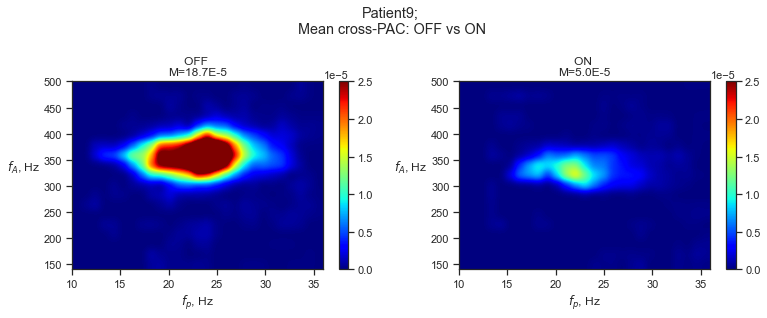

In [46]:
beta_params = cross_pac.beta_params
hfo_params = cross_pac.hfo_params

vmax = 2.5e-5

with open('../path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'Mean PAC comodulograms', 'by patients')

try:
    os.makedirs(save_path)
except:
    pass


for i in range(len(patients)):
    patient = patients[i]
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    plt.suptitle(f"{patient.name};\n Mean cross-PAC: OFF vs ON")
    
    ax = axes[0]
    data = cross_pacs_for_patient_off[i]
    if i == 7: data = data / p8_divisor
    im = comodulogram(data.mean(axis=0), 
                     beta_params, 
                     hfo_params, 
                     pvalues=cross_pac.pvalues, 
                     significant=False, significance=0.01,
                     vmax=vmax, smooth=True,
                     ax=ax)
    norm = compute_matrix_norm(cross_pacs_for_patient_off[i].mean(axis=0))
    ax.set_title(f"OFF \nM={norm * 1e5:.1f}E-5")
    ax.set_xlabel(r"$f_p$, Hz")
    ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
    cbar = fig.colorbar(im, ax=ax)
    cbar.formatter.set_powerlimits((0, 0))
    #ax.grid()
    
    ax = axes[1]
    data = cross_pacs_for_patient_on[i]
    if i == 7: data = data / p8_divisor
    im = comodulogram(data.mean(axis=0), 
                     beta_params, 
                     hfo_params, 
                     pvalues=cross_pac.pvalues, 
                     significant=False, significance=0.01,
                     vmax=vmax, smooth=True,
                     ax=ax)
    norm = compute_matrix_norm(cross_pacs_for_patient_on[i].mean(axis=0))
    ax.set_title(f"ON \nM={norm * 1e5:.1f}E-5")
    ax.set_xlabel(r"$f_p$, Hz")
    ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
    cbar = fig.colorbar(im, ax=ax)
    cbar.formatter.set_powerlimits((0, 0))
    #ax.grid()
    plt.tight_layout()
    fig_path = os.path.join(save_path, f"{patient.name} Mean cross-PAC OFF vs ON.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')

### Same but day counts

In [21]:
#patients = [p1, p2, p3, p4, p5, p6]

# each would contain an array of shape n_pacs x shape(pac_matrix)

days_for_patient = [[] for _ in range(len(patients))]

cross_pacs_for_patient_off = [[] for _ in range(len(patients))]
inter_pacs_for_patient_off = [[] for _ in range(len(patients))]
all_pacs_for_patient_off = [[] for _ in range(len(patients))]

cross_pacs_for_patient_on = [[] for _ in range(len(patients))]
inter_pacs_for_patient_on = [[] for _ in range(len(patients))]
all_pacs_for_patient_on = [[] for _ in range(len(patients))]

for i, patient in enumerate(patients):
    
    conditions = [c for c in patient.conditions if 'Rest 180sec' in c]
    print(conditions)
    for condition in tqdm(conditions, total=len(conditions)):
        day, ldopa, movement = retrieve_condition_name(condition)
        for pp in patient.placements:
            for pa in patient.placements:
                if not pac_exists(patient, condition, pp, pa):
                    continue

                # if irrelevant cross-PAC (not all conditions will be available)
                if (pp != pa) and (pp not in patient.cross_placements or pa not in patient.cross_placements):
                    continue

                # Get PAC power
                pac = patient.pac[condition][pp][pa]
                if (pp != pa) and pac.pac_matrix.shape != (19, 27):
                    continue

                # if shape is not equal to specified one

                ## getting only significant PAC + leaving only "clustered" entries
                sig_pac = get_sig_pac(pac, significance=0.01, mask_lonely=True)

                ## if cross_pac
                if pp != pa:
                    res = sig_pac
                    # append cross_pac
                    if ldopa == 'OFF':
                        cross_pacs_for_patient_off[i].append(res)
                    if ldopa == 'ON':
                        cross_pacs_for_patient_on[i].append(res)
                else:
                    # reduce size to match cross-PAC
                    beta10 = np.argmin(np.abs(pac.beta_freqs - 10))
                    beta36 = np.argmin(np.abs(pac.beta_freqs - 36))
                    hfo140 = np.argmin(np.abs(pac.hfo_freqs - 140))
                    res = sig_pac[hfo140:, beta10:beta36 + 1]
                    # append inter-PAC
                    if ldopa == 'OFF':
                        inter_pacs_for_patient_off[i].append(res)
                    if ldopa == 'ON':
                        inter_pacs_for_patient_on[i].append(res)
                # append PAC no matter inter- or cross-
                if ldopa == 'OFF':
                        all_pacs_for_patient_off[i].append(res)
                if ldopa == 'ON':
                        all_pacs_for_patient_on[i].append(res)
                        
                days_for_patient[i].append(int(day[0]))

                    #print(f"{pp}-{pa}: {res.shape}")
        # after computing one patients convert to np.arrays
    cross_pacs_for_patient_off[i] = np.array(cross_pacs_for_patient_off[i])
    inter_pacs_for_patient_off[i] = np.array(inter_pacs_for_patient_off[i])
    all_pacs_for_patient_off[i] = np.array(all_pacs_for_patient_off[i])

    cross_pacs_for_patient_on[i] = np.array(cross_pacs_for_patient_on[i])
    inter_pacs_for_patient_on[i] = np.array(inter_pacs_for_patient_on[i])
    all_pacs_for_patient_on[i] = np.array(all_pacs_for_patient_on[i])

['1Day ON Rest 180sec', '5Day ON Rest 180sec', '5Day OFF Rest 180sec', '1Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['5Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day ON Rest 180sec', '1Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['1Day ON Rest 180sec', '5Day ON Rest 180sec', '5Day OFF Rest 180sec', '1Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['5Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day ON Rest 180sec', '1Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['5Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day ON Rest 180sec', '1Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['1Day ON Rest 180sec', '1Day OFF Rest 180sec']


  0%|          | 0/2 [00:00<?, ?it/s]

['1Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day ON Rest 180sec', '5Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['1Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day ON Rest 180sec', '5Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

['1Day OFF Rest 180sec', '1Day ON Rest 180sec', '5Day ON Rest 180sec', '5Day OFF Rest 180sec']


  0%|          | 0/4 [00:00<?, ?it/s]

### Cross-PAC by patients and days TODO

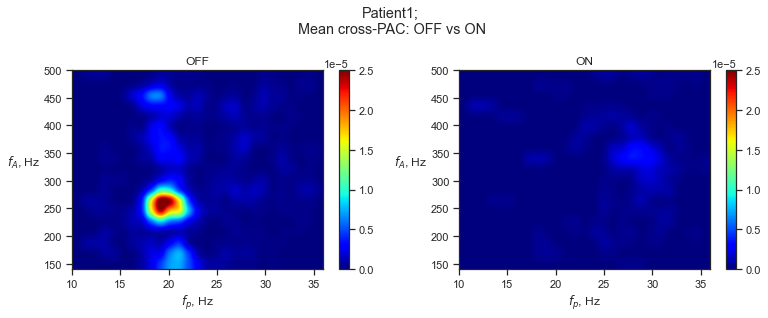

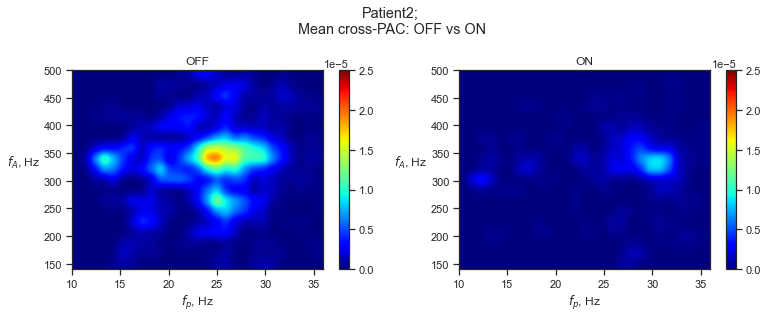

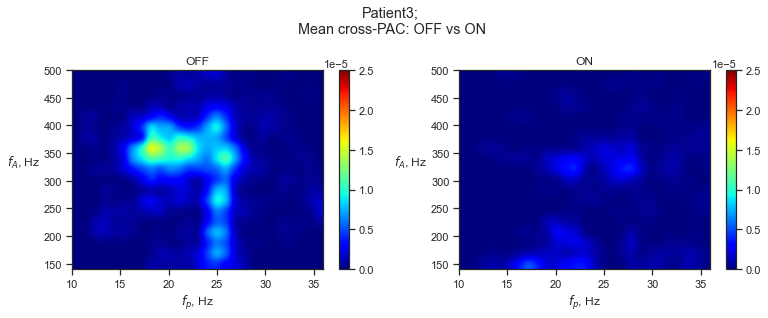

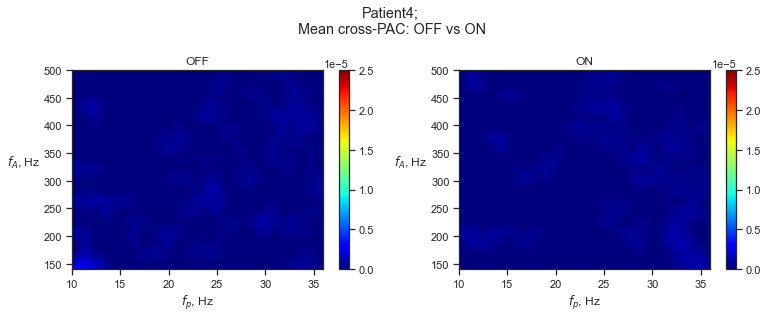

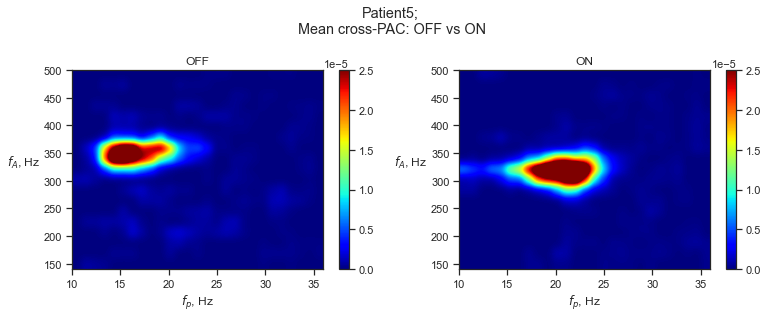

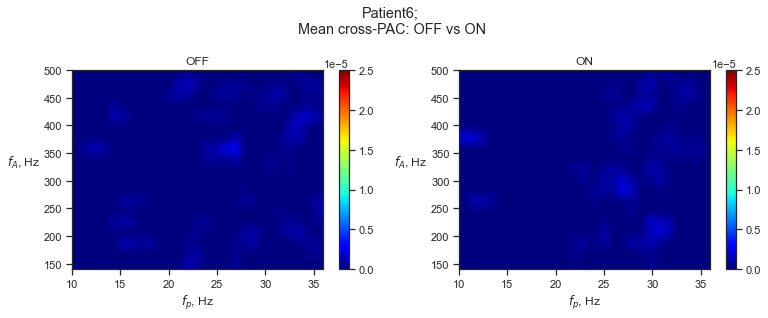

In [20]:
beta_params = cross_pac.beta_params
hfo_params = cross_pac.hfo_params

vmax = 2.5e-5

with open('path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'Mean PAC comodulograms', 'by patients-days')

try:
    os.makedirs(save_path)
except:
    pass


for i in range(len(patients)):
    for day in [1, 5]:
        patient = patients[i]
        fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
        plt.suptitle(f"{patient.name}, Day {day};\n Mean cross-PAC: OFF vs ON")

        ax = axes[0]
        
        im = comodulogram(cross_pacs_for_patient_off[i].mean(axis=0), 
                         beta_params, 
                         hfo_params, 
                         pvalues=cross_pac.pvalues, 
                         significant=False, significance=0.01,
                         vmax=vmax, smooth=True,
                         ax=ax)
        ax.set_title("OFF")
        ax.set_xlabel(r"$f_p$, Hz")
        ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        #ax.grid()

        ax = axes[1]
        im = comodulogram(cross_pacs_for_patient_on[i].mean(axis=0), 
                         beta_params, 
                         hfo_params, 
                         pvalues=cross_pac.pvalues, 
                         significant=False, significance=0.01,
                         vmax=vmax, smooth=True,
                         ax=ax)
        ax.set_title("ON")
        ax.set_xlabel(r"$f_p$, Hz")
        ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter.set_powerlimits((0, 0))
        #ax.grid()
        plt.tight_layout()
        fig_path = os.path.join(save_path, f"{patient.name} Mean cross-PAC OFF vs ON.png")
        plt.savefig(fig_path, dpi=180, bbox_inches='tight')

## Mean global cross-pac and inter-PAC OFF vs ON

In [22]:
all_inter_pacs_off = np.concatenate([inter_pacs_for_patient_off[i] for i in range(len(patients))], axis=0)
all_cross_pacs_off = np.concatenate([cross_pacs_for_patient_off[i] for i in range(len(patients))], axis=0)

all_inter_pacs_on = np.concatenate([inter_pacs_for_patient_on[i] for i in range(len(patients))], axis=0)
all_cross_pacs_on = np.concatenate([cross_pacs_for_patient_on[i] for i in range(len(patients))], axis=0)

all_inter_pacs_off.shape

(510, 19, 27)

### Mean global cross-PAC

In [34]:
from statsmodels.robust.scale import huber

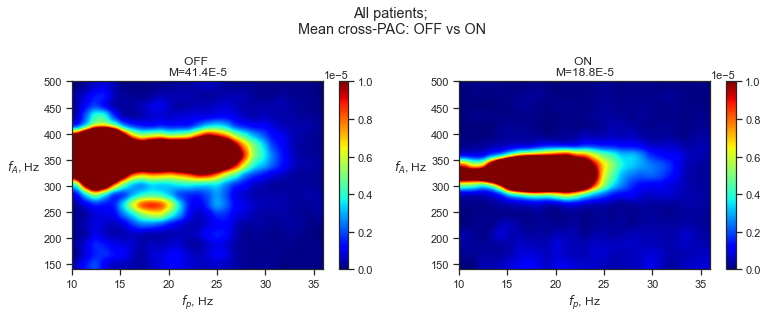

In [37]:
with open('../path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'Mean PAC comodulograms', 'global')

try:
    os.makedirs(save_path)
except:
    pass

vmax=1e-5

func = lambda arr: np.mean(arr, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
plt.suptitle(f"All patients;\n Mean cross-PAC: OFF vs ON")

ax = axes[0]

im = comodulogram(func(all_cross_pacs_off), 
                 beta_params, 
                 hfo_params, 
                 pvalues=cross_pac.pvalues, 
                 significant=False, significance=0.01,
                 vmax=vmax, smooth=True,
                 ax=ax)
norm = compute_matrix_norm(all_cross_pacs_off.mean(axis=0))
ax.set_title(f"OFF \nM={norm * 1e5:.1f}E-5")
ax.set_xlabel(r"$f_p$, Hz")
ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
cbar = fig.colorbar(im, ax=ax)
cbar.formatter.set_powerlimits((0, 0))
#ax.grid()

ax = axes[1]
im = comodulogram(func(all_cross_pacs_on), 
                 beta_params, 
                 hfo_params, 
                 pvalues=cross_pac.pvalues, 
                 significant=False, significance=0.01,
                 vmax=vmax, smooth=True,
                 ax=ax)
norm = compute_matrix_norm(all_cross_pacs_on.mean(axis=0))
ax.set_title(f"ON \nM={norm * 1e5:.1f}E-5")
ax.set_xlabel(r"$f_p$, Hz")
ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
cbar = fig.colorbar(im, ax=ax)
cbar.formatter.set_powerlimits((0, 0))
#ax.grid()
plt.tight_layout()
fig_path = os.path.join(save_path, f"{patient.name} Mean global cross-PAC OFF vs ON.png")
plt.savefig(fig_path, dpi=200, bbox_inches='tight')

### Mean global inter-PAC

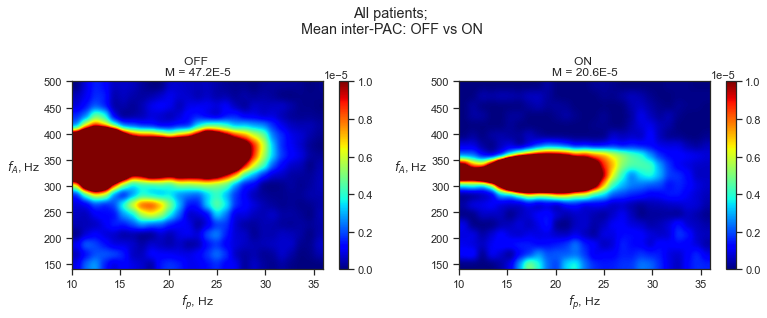

In [39]:
with open('../path_data.txt', 'r') as f:
    data_path = f.readline()
    
vmax=1e-5

save_path = os.path.join(data_path, 'im_common', 'Mean PAC comodulograms', 'global')

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
plt.suptitle(f"All patients;\n Mean inter-PAC: OFF vs ON")

ax = axes[0]

im = comodulogram(all_inter_pacs_off.mean(axis=0), 
                 beta_params, 
                 hfo_params, 
                 pvalues=cross_pac.pvalues, 
                 significant=False, significance=0.01,
                 vmax=vmax, smooth=True,
                 ax=ax)
norm = compute_matrix_norm(all_inter_pacs_off.mean(axis=0))
ax.set_title(f"OFF \nM = {norm * 1e5:.1f}E-5")
ax.set_xlabel(r"$f_p$, Hz")
ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
cbar = fig.colorbar(im, ax=ax)
cbar.formatter.set_powerlimits((0, 0))
#ax.grid()

ax = axes[1]
im = comodulogram(all_inter_pacs_on.mean(axis=0), 
                 beta_params, 
                 hfo_params, 
                 pvalues=cross_pac.pvalues, 
                 significant=False, significance=0.01,
                 vmax=vmax, smooth=True,
                 ax=ax)
norm = compute_matrix_norm(all_inter_pacs_on.mean(axis=0))
ax.set_title(f"ON \nM = {norm * 1e5:.1f}E-5")
ax.set_xlabel(r"$f_p$, Hz")
ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
cbar = fig.colorbar(im, ax=ax)
cbar.formatter.set_powerlimits((0, 0))
#ax.grid()
plt.tight_layout()
fig_path = os.path.join(save_path, f"{patient.name} Mean global inter-PAC OFF vs ON.png")
plt.savefig(fig_path, dpi=180, bbox_inches='tight')

### Now only patients 1, 2, 3

In [15]:
patient_picks = []

all_inter_pacs_off = np.concatenate([inter_pacs_for_patient_off[i] for i in [0, 1, 2]], axis=0)
all_cross_pacs_off = np.concatenate([cross_pacs_for_patient_off[i] for i in [0, 1, 2]], axis=0)

all_inter_pacs_on = np.concatenate([inter_pacs_for_patient_on[i] for i in [0, 1, 2]], axis=0)
all_cross_pacs_on = np.concatenate([cross_pacs_for_patient_on[i] for i in [0, 1, 2]], axis=0)

all_inter_pacs_off.shape

(185, 19, 27)

### Mean global cross-PAC

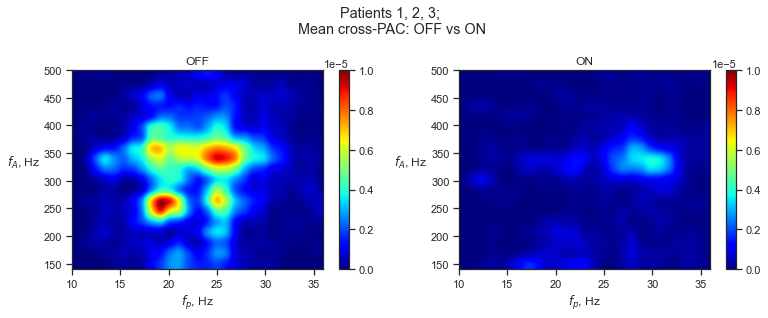

In [16]:
with open('path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'Mean PAC comodulograms', 'global')

try:
    os.makedirs(save_path)
except:
    pass

vmax=1e-5

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
plt.suptitle(f"Patients 1, 2, 3;\n Mean cross-PAC: OFF vs ON")

ax = axes[0]

im = comodulogram(all_cross_pacs_off.mean(axis=0), 
                 beta_params, 
                 hfo_params, 
                 pvalues=cross_pac.pvalues, 
                 significant=False, significance=0.01,
                 vmax=vmax, smooth=True,
                 ax=ax)
ax.set_title("OFF")
ax.set_xlabel(r"$f_p$, Hz")
ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
cbar = fig.colorbar(im, ax=ax)
cbar.formatter.set_powerlimits((0, 0))
#ax.grid()

ax = axes[1]
im = comodulogram(all_cross_pacs_on.mean(axis=0), 
                 beta_params, 
                 hfo_params, 
                 pvalues=cross_pac.pvalues, 
                 significant=False, significance=0.01,
                 vmax=vmax, smooth=True,
                 ax=ax)
ax.set_title("ON")
ax.set_xlabel(r"$f_p$, Hz")
ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
cbar = fig.colorbar(im, ax=ax)
cbar.formatter.set_powerlimits((0, 0))
#ax.grid()
plt.tight_layout()
fig_path = os.path.join(save_path, f"{patient.name} Mean global cross-PAC OFF vs ON - p123.png")
plt.savefig(fig_path, dpi=200, bbox_inches='tight')

### Mean global inter-PAC

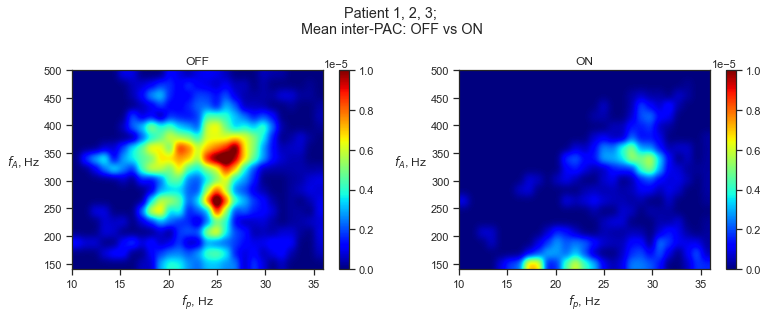

In [17]:
with open('path_data.txt', 'r') as f:
    data_path = f.readline()
    
vmax=1e-5

save_path = os.path.join(data_path, 'im_common', 'Mean PAC comodulograms', 'global')

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
plt.suptitle(f"Patient 1, 2, 3;\n Mean inter-PAC: OFF vs ON")

ax = axes[0]

im = comodulogram(all_inter_pacs_off.mean(axis=0), 
                 beta_params, 
                 hfo_params, 
                 pvalues=cross_pac.pvalues, 
                 significant=False, significance=0.01,
                 vmax=vmax, smooth=True,
                 ax=ax)
ax.set_title("OFF")
ax.set_xlabel(r"$f_p$, Hz")
ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
cbar = fig.colorbar(im, ax=ax)
cbar.formatter.set_powerlimits((0, 0))
#ax.grid()

ax = axes[1]
im = comodulogram(all_inter_pacs_on.mean(axis=0), 
                 beta_params, 
                 hfo_params, 
                 pvalues=cross_pac.pvalues, 
                 significant=False, significance=0.01,
                 vmax=vmax, smooth=True,
                 ax=ax)
ax.set_title("ON")
ax.set_xlabel(r"$f_p$, Hz")
ax.set_ylabel(r"$f_A$, Hz", rotation=0, labelpad=20)
cbar = fig.colorbar(im, ax=ax)
cbar.formatter.set_powerlimits((0, 0))
#ax.grid()
plt.tight_layout()
fig_path = os.path.join(save_path, f"{patient.name} Mean global inter-PAC OFF vs ON - p123.png")
plt.savefig(fig_path, dpi=200, bbox_inches='tight')